# Import

In [1]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


In [42]:
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import copy
import numpy as np
#import networkx as nx


import datetime as dt
pd.set_option('display.max_columns', 500)

import time
%load_ext autoreload

from collections import defaultdict
from collections import Counter

from functools import lru_cache
import seaborn as sns

from scipy.special import expit
from functools import partial
from multiprocessing import Pool
from tqdm import tqdm
import random 

from scipy.special import logit
from scipy.special import expit


class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ohtsuki_model

In [3]:
class ohtsuki_model():
    def __init__(self, links, w, b, all_coop=False, extra_random=0):
        
        #network properties 
        self.links = links
        self.n = len(links.keys())
        
        #define interactions
        self.b = b
        self.w = w
        
        #inizialize nodes
        self.initial_all_coop = all_coop
        self.strategy = np.array([all_coop]*self.n)
    
        #automatic flip one agents on init
        self.flip_agent(0) 
        
        # number of coops for stopping rule
        self.ncoop = sum(self.strategy)
    
    
    
    #fip one node strategy
    def flip_agent(self, index_flipped):
        self.strategy[index_flipped] = not self.strategy[index_flipped]
         
        
    # get the payoff of a single node    
    def compute_payoff_node(self, node):
        
        kcoop = sum(self.strategy[self.links[node]])
        kdef = len(self.links[node]) - kcoop
        k = kcoop + kdef
        
        # if cooperator
        if self.strategy[node]:
            payoff = (self.b * kcoop) - k
            
        # if defector     
        else: 
            payoff = (self.b * kcoop)
        
        #correct for positive values
        payoff += k
        
        #selection 
        return (1 - self.w) + self.w*(payoff)
    
    
    
    def make_action(self):
        
        randomNode = random.randrange(0, self.n)
        
        #early stop if my neighbours are all equal
        early_stop = True
        for v in self.links[randomNode]:
            if self.strategy[v] != self.strategy[randomNode]:
                early_stop = False
                break
        if early_stop: return False
                
            
        
        pyf_randomNode = self.compute_payoff_node(randomNode)
        pyf_neighbors_coop = 0
        pyf_neighbors_def = 0
        
        for v in self.links[randomNode]:
            if self.strategy[v]: 
                pyf_neighbors_coop += self.compute_payoff_node(v)
            else: 
                pyf_neighbors_def += self.compute_payoff_node(v)
        

        if self.strategy[randomNode]:
            probChange = pyf_neighbors_def / (pyf_neighbors_def + pyf_neighbors_coop)
        else:
            probChange = pyf_neighbors_coop / (pyf_neighbors_def + pyf_neighbors_coop)
        
        
        if random.random() < probChange:
            #update number of coop for stopping
            if self.strategy[randomNode]: self.ncoop -= 1
            else: self.ncoop += 1
            
            #change
            self.strategy[randomNode] = not self.strategy[randomNode]
        
   
        if self.ncoop == self.n or self.ncoop == 0:
            return True
        return False


def crete_link_circle(n, neighbours):
    assert neighbours%2==0
    
    links = defaultdict(list)
    for i in range(n):
        left = [(i-j-1)%n for j in range(int(neighbours/2))]
        right = [(i+j+1)%n for j in range(int(neighbours/2))]
        
        links[i] = left+right
        
    return dict(links)


In [11]:
def _runModel(seed, c):  
    c = copy.deepcopy(c)
    #random.seed(int(time.time()*1000000 + seed))
    itera = 0

    while not c.make_action():
        itera += 1 
    
    return all([i != c.initial_all_coop for i in c.strategy]), itera


def runModel(nRun, c):
    
    __runModel = partial(_runModel, c = c)
    with Pool(6) as p:
          r = list(tqdm(p.imap(__runModel, range(nRun)), total=nRun)) 
    
    final_r = [i[0] for i in r]
    iterations = [(i[1],i[0]) for i in r]
    
    fix = sum(final_r)/len(final_r)
    return fix, iterations

## Test neutral 1/N

In [7]:
fixs = []
n_nodes = [2, 3, 4, 5, 7, 10, 20, 30, 50]

for n_node in n_nodes:
    
    ots = ohtsuki_model(crete_link_circle(n_node, 2), 0, 0)
    res = runModel(10000, ots)
    fixs.append(res[0])

100%|██████████| 10000/10000 [00:16<00:00, 603.52it/s]


In [8]:
fixs

[0.5051, 0.3263, 0.2527, 0.2063, 0.1436, 0.1057, 0.0463, 0.0341, 0.0204]

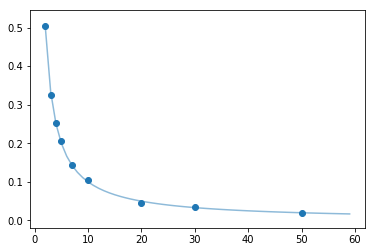

In [10]:
plt.scatter(n_nodes, fixs)
plt.plot(range(2,60), [1/i for i in range(2,60)], alpha=0.5)

## Test b/c > K

In [12]:
ots = ohtsuki_model(crete_link_circle(100, 2), 0.01, 2)
res = runModel(100000, ots)
res[0]

100%|██████████| 100000/100000 [11:10<00:00, 149.15it/s]


0.00958

In [13]:
ots = ohtsuki_model(crete_link_circle(100, 2), 0.01, 2.2)
res = runModel(100000, ots)
res[0]

100%|██████████| 100000/100000 [11:32<00:00, 144.39it/s]


0.0105

In [14]:
ots = ohtsuki_model(crete_link_circle(100, 2), 0.01, 1.8)
res = runModel(100000, ots)
res[0]

100%|██████████| 100000/100000 [10:29<00:00, 158.83it/s]


0.00926

## Test circle paper

In [ ]:
fix = list()
n_nodes = 100

bs = [np.arange(1.6, 2.5, 0.2),np.arange(3.6, 4.5, 0.2), np.arange(12.2, 13, 0.2)]
neighbours = [2,4,10]


n_bs_fix = list(zip(neighbours, bs, [list() for i in range(len(neighbours))]))

for _neighbours, _bs, _fix in n_bs_fix:
    for b in _bs:
        ots = ohtsuki_model(crete_link_circle(n_nodes, _neighbours), 0.01, b)
        res = runModel(100000, ots)
        _fix.append(res[0])

  2%|▏         | 1748/100000 [00:14<19:25, 84.31it/s]

In [43]:
with open("./ohtsuki_figure_2(100N_10000iter_w0.01)", "w") as f:
    json.dump(n_bs_fix, f, cls=NumpyEncoder)

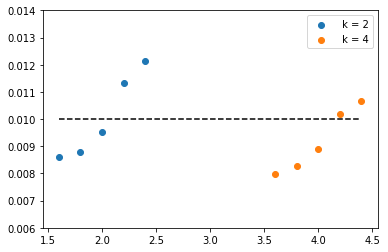

In [32]:
for _neighbours, _bs, _fix in n_bs_fix[0:2]:
    plt.scatter(_bs, _fix, label= f" k = {_neighbours}")
    
plt.hlines(1/n_nodes, min(j for _neighbours, _bs, _fix in n_bs_fix[0:2] for j in _bs), max(j for _neighbours, _bs, _fix in n_bs_fix[0:2] for j in _bs), linestyles= 'dashed')
plt.legend()
_ = plt.ylim(0.006,0.014)

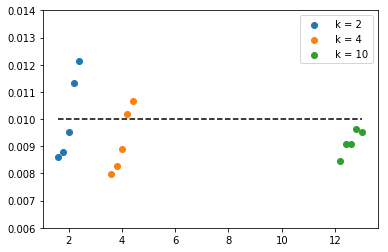

In [33]:
for _neighbours, _bs, _fix in n_bs_fix:
    plt.scatter(_bs, _fix, label= f" k = {_neighbours}")
    
plt.hlines(1/n_nodes, min(j for _neighbours, _bs, _fix in n_bs_fix for j in _bs), max(j for _neighbours, _bs, _fix in n_bs_fix for j in _bs), linestyles= 'dashed')
plt.legend()
_ = plt.ylim(0.006,0.014)